In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *

C:\ProgramData\Miniconda3\envs\opt\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Miniconda3\envs\opt\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Miniconda3\envs\opt\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.
fname = '../ECD_circuits/state_prep/kitten_code_states/state_+Y_F_99.npz'
betas = np.load(fname)['betas']
phis = np.load(fname)['phis']
thetas = np.load(fname)['thetas']
print('betas:' + str(betas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[-1.6791348 -0.45738742j  1.442646  -1.5703454j  -0.42270523+0.8626163j
  0.24717523-1.3528787j  -0.40499672-0.02108315j -0.04202466-0.05907362j]
phis:[ 0.        -1.4795454 -1.8798764 -1.1668798  1.0934193 -2.6821597]
thetas:[-1.5768628 -1.6636173  2.5807245  2.1501944 -1.7170584  1.5558712]


In [4]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#Here, we are making a "FakeCavity" and a "FakeQubit" with parameters found from experimental calibrations.

storage_params = {
        "chi_kHz": -33, #dispersive shift
        "chi_prime_Hz": -1, #second order dispersive shift
        "Ks_Hz": 0, #Kerr correction not yet implemented.
        "epsilon_m_MHz": 400, #largest oscillator drive amplitude in MHz (max|epsilon|)
        "unit_amp": 0.01, #DAC unit amp of gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement sigma
        "chop": 4, #oscillator displacement chop (number of stds. to include in gaussian pulse)
    }
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.

#calculating conversion between qubit DAC units and MHz (Omega)
pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses
buffer_time = 4

In [5]:
#generating the conditional displacement circuit.
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a displacement
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)
cavity_dac_pulse, qubit_dac_pulse, = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse']

C:\ProgramData\Miniconda3\envs\opt\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'ns')

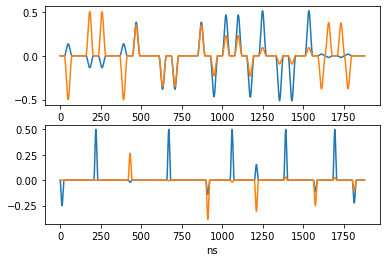

In [7]:
#plotting the pulse
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(cavity_dac_pulse))
axs[0].plot(np.imag(cavity_dac_pulse))
axs[1].plot(np.real(qubit_dac_pulse))
axs[1].plot(np.imag(qubit_dac_pulse))
plt.xlabel('ns')